Train Regression (3 CLIP scores, and T -> predict best T) Model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import os
import random

random_seed = 42
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Load Data

In [2]:
save_path = Path('/home/lbw/CLODE_scores_npy')

# (485, 2): 485개 이미지에 대한, best T값과 그때의 PSNR
results = np.load(save_path / 'results.npy')

# (485 * 30, 3): 485개 이미지에 대한, 30개의 T값에 대한 score. 3 = [idx, T, score]
brightness_scores = np.load(save_path / 'brightness_scores.npy')
noisiness_scores = np.load(save_path / 'noisiness_scores.npy')
quality_scores = np.load(save_path / 'quality_scores.npy')

print(results.shape, brightness_scores.shape, noisiness_scores.shape, quality_scores.shape)

(485, 2) (14550, 3) (14550, 3) (14550, 3)


In [16]:
print(brightness_scores[:31, 1])

[2.         2.10344828 2.20689655 2.31034483 2.4137931  2.51724138
 2.62068966 2.72413793 2.82758621 2.93103448 3.03448276 3.13793103
 3.24137931 3.34482759 3.44827586 3.55172414 3.65517241 3.75862069
 3.86206897 3.96551724 4.06896552 4.17241379 4.27586207 4.37931034
 4.48275862 4.5862069  4.68965517 4.79310345 4.89655172 5.
 2.        ]


In [4]:
NUM_IMAGES = results.shape[0]
NUM_T = 30

In [5]:
X = np.zeros((NUM_IMAGES, NUM_T, 4))

for i in range(NUM_IMAGES):
    for j in range(NUM_T):
        X[i, j, 0] = brightness_scores[i * NUM_T + j, 2]
        X[i, j, 1] = noisiness_scores[i * NUM_T + j, 2]
        X[i, j, 2] = quality_scores[i * NUM_T + j, 2]
        X[i, j, 3] = brightness_scores[i, 1]        # T value

y = results[:, 0]

X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

print(X.shape, y.shape)

torch.Size([485, 30, 4]) torch.Size([485])


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([388, 30, 4]) torch.Size([97, 30, 4]) torch.Size([388]) torch.Size([97])


In [7]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(list(zip(X_train, y_train)), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), batch_size=batch_size, shuffle=False)

Load Model

In [8]:
class Regressor(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=64):
        super(Regressor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim*2)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=2)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        # [batch_size, T, hidden_dim]
        x = self.mlp(x)
        # [seq_len = T, batch, hidden_dim]
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        # [batch, hidden_dim]
        x = x.permute(1, 0, 2).mean(dim=1)
        # [batch, 1]
        T_pred = self.fc(x).squeeze(-1)
        return T_pred

Train the Model

In [9]:
from tqdm import tqdm

num_epochs = 2000
train_losses = []
test_losses = []
best_test_loss = 10
best_epoch = 0
learning_rate = 1e-4

regressor = Regressor(input_dim = 4, hidden_dim = 64).to(device)
criterion = torch.nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(regressor.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)


for epoch in tqdm(range(num_epochs)):
    regressor.train()
    epoch_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        y_pred = regressor(X_batch)
        loss = criterion(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    regressor.eval()
    test_loss = 0.0
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = regressor(X_batch)
            test_loss += criterion(y_pred, y_batch).item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    
    if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model = regressor.state_dict()
            best_epoch = epoch


model_path = Path("/home/soom/CLODE/soom_outputs")
model_path.mkdir(exist_ok=True, parents=True)

torch.save(best_model, (model_path / f'att_regression_{best_epoch}.pth'))

/home/soom/miniconda3/envs/clode/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/home/soom/miniconda3/envs/clode/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
100%|██████████| 2000/2000 [08:25<00:00,  3.95it/s]


Plot Train Result and Performance

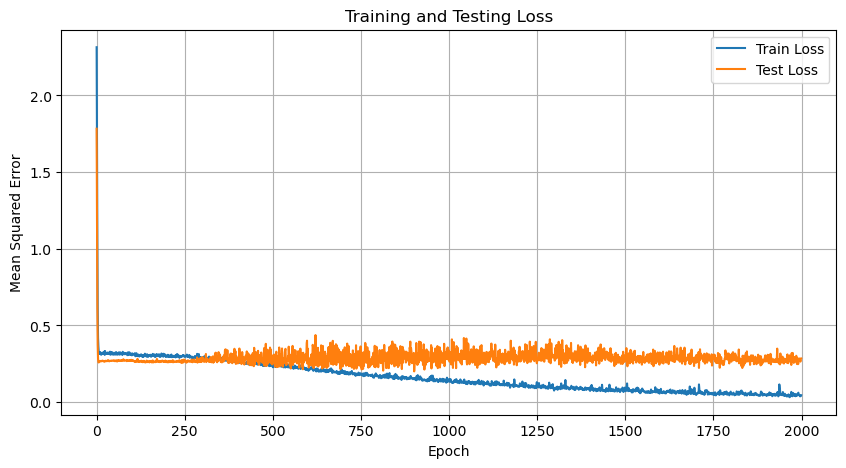

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Loss')
plt.legend()
plt.grid(True)
plt.savefig(model_path / 'regression_training.png')
plt.show()

MAE: 0.2115, RMSE: 0.2779


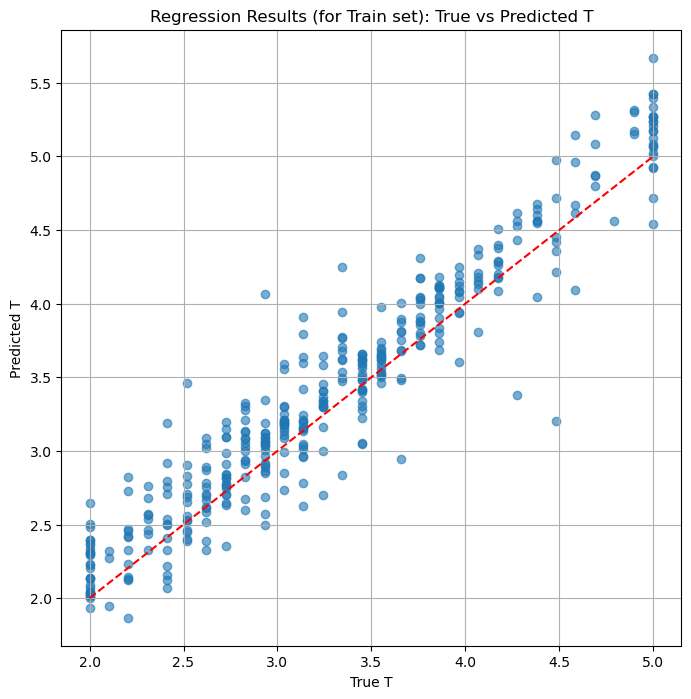

MAE: 0.6303, RMSE: 0.8478


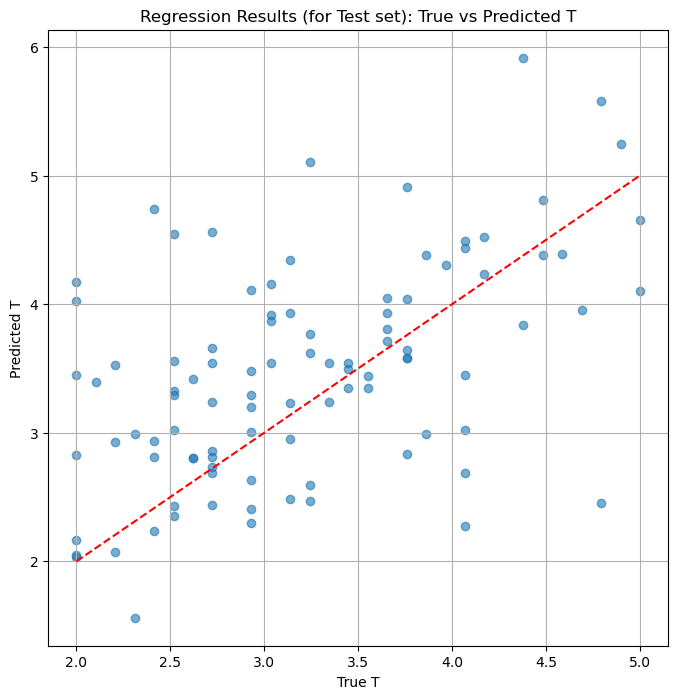

In [11]:
regressor.eval()

def plot_regression_results(y_true, y_pred, title):
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    
    print(f'MAE: {mae:.4f}, RMSE: {rmse:.4f}')

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True T')
    plt.ylabel('Predicted T')
    plt.title(title)
    plt.grid(True)
    plt.show()

with torch.no_grad():
    y_pred = regressor(X_train).cpu().numpy()
    y_true = y_train.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Train set): True vs Predicted T')

    y_pred = regressor(X_test).cpu().numpy()
    y_true = y_test.cpu().numpy()
    
    plot_regression_results(y_true, y_pred, 'Regression Results (for Test set): True vs Predicted T')